In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score,accuracy_score,roc_curve,classification_report

LOADING DATASET

In [3]:
df = pd.read_csv("dataset/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
df.shape

(159571, 8)

## EXPLORATORY DATA ANALYSIS

In [8]:
column_sum = df.loc[:, df.columns[2:]].sum() # COLUMN-WISE 
# : to select all rows and 2: to select columns from index 2
# .sum() returns number of comments that are toxic since toxic belongs to [0/1]
column_sum

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [9]:
row_sum = df.loc[:, df.columns[2:]].sum(axis=1) #ROW-WISE
row_greater_than_zero = df[row_sum>0]
row_greater_than_zero.shape

(16225, 8)

In [10]:
16225/159571 * 100 # 10% are only labelled in at least one column

10.167887648758233

In [11]:
print("Total Number of Comments: ",len(df))
print("Total Number of Unlabelled Comments: ",df[row_sum == 0].shape[0])
print("Total Number of Labels: ",column_sum.sum())
print("Total Number of Rows with at least one label: ",row_greater_than_zero.shape[0])

Total Number of Comments:  159571
Total Number of Unlabelled Comments:  143346
Total Number of Labels:  35098
Total Number of Rows with at least one label:  16225


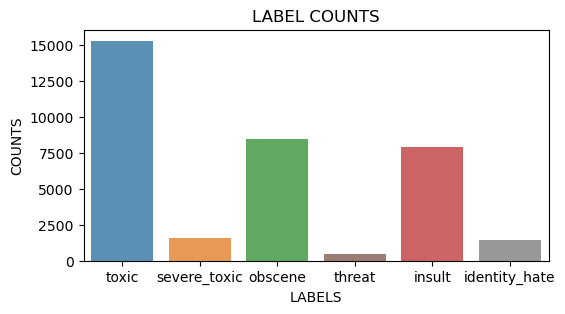

In [12]:
plt.figure(figsize=(6,3))
ax = sns.barplot(x=column_sum.index,y=column_sum.values,alpha=0.8,palette=['tab:blue','tab:orange','tab:green','tab:brown','tab:red','tab:grey'])
plt.title('LABEL COUNTS')
plt.xlabel('LABELS')
plt.ylabel('COUNTS')
plt.show()

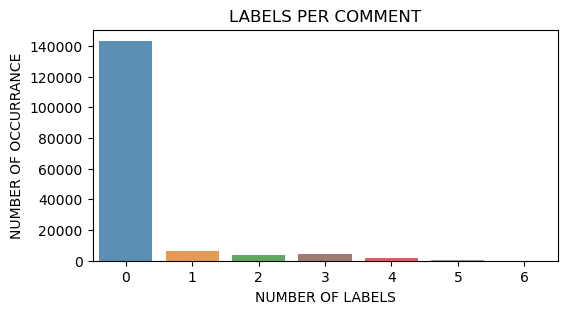

In [14]:
plt.figure(figsize=(6,3))
ax = sns.countplot(x=row_sum.values,alpha=0.8,palette=['tab:blue','tab:orange','tab:green','tab:brown','tab:red','tab:grey'])
plt.title('LABELS PER COMMENT')
plt.xlabel('NUMBER OF LABELS')
plt.ylabel('NUMBER OF OCCURRANCE')
plt.show()

## Data Preprocessing

In [15]:
df = df.drop(columns=["id"],axis=1)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### REMOVING STOPWORDS

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/dipesh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:

stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return " ".join(no_stopword_text)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'scuse", "excuse", text)
    
    # Keep only alphabetic characters, replace others with space
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    
    text = text.strip()  # Remove leading/trailing spaces
    return text


# Initialize the Snowball stemmer for English
stemmer = SnowballStemmer("english")

# Function for stemming a sentence
def stemming(sentence):
    stemmed_sentence = [stemmer.stem(word) for word in sentence.split()]
    return " ".join(stemmed_sentence)



###### Preprocess the COMMENT

In [19]:
df['comment_text'] = df['comment_text'].apply(lambda x:  remove_stopwords(x))
df['comment_text'] = df['comment_text'].apply(lambda x:  clean_text(x))
df['comment_text'] = df['comment_text'].apply(lambda x:  stemming(x))
df.head() #1minute

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explan whi edit made usernam hardcor metallica...,0,0,0,0,0,0
1,d aww he match background colour i am seem stu...,0,0,0,0,0,0
2,hey man i am realli tri edit war it guy consta...,0,0,0,0,0,0
3,more i cannot make real suggest improv i wonde...,0,0,0,0,0,0
4,you sir hero ani chanc rememb page that on,0,0,0,0,0,0


##### Train Test Split

In [30]:
X = df['comment_text']
y = df.drop(columns=['comment_text'],axis=1)

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [35]:
def run_pipeline(pipeline:Pipeline,X_train,X_test,y_train,y_test):
    pipeline.fit(X_train,y_train)
    predictions = pipeline.predict(X_test)
    pred_probs = pipeline.predict_proba(X_test)
    print("roc_auc_score: ",roc_auc_score(y_test,pred_probs))
    print("accuracy: ",accuracy_score(y_test,predictions))
    print("classification_report:")
    print(classification_report(y_test,predictions,target_names=y_train.columns))

In [36]:
NB_pipeline = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english')),
    ('nb_model',OneVsRestClassifier(MultinomialNB(),n_jobs=-1)),
])
LR_pipeline = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words='english')),
    ('nb_model',OneVsRestClassifier(LogisticRegression(),n_jobs=-1)),
])

In [37]:
run_pipeline(NB_pipeline,X_train,X_test,y_train,y_test)

roc_auc_score:  0.8646130365419943
accuracy:  0.9003603321322262
classification_report:
               precision    recall  f1-score   support

        toxic       0.99      0.22      0.36      3056
 severe_toxic       0.00      0.00      0.00       321
      obscene       0.98      0.14      0.24      1715
       threat       0.00      0.00      0.00        74
       insult       0.96      0.06      0.12      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.98      0.14      0.25      7074
    macro avg       0.49      0.07      0.12      7074
 weighted avg       0.88      0.14      0.24      7074
  samples avg       0.02      0.01      0.01      7074



In [38]:
run_pipeline(LR_pipeline,X_train,X_test,y_train,y_test)

roc_auc_score:  0.9791285644702262
accuracy:  0.9186902710324298
classification_report:
               precision    recall  f1-score   support

        toxic       0.91      0.62      0.74      3056
 severe_toxic       0.59      0.29      0.39       321
      obscene       0.91      0.65      0.76      1715
       threat       0.53      0.14      0.22        74
       insult       0.82      0.51      0.62      1614
identity_hate       0.71      0.16      0.26       294

    micro avg       0.87      0.56      0.68      7074
    macro avg       0.74      0.39      0.50      7074
 weighted avg       0.86      0.56      0.68      7074
  samples avg       0.06      0.05      0.05      7074



#### Test Prediction

In [44]:
X_test.sample(1).values[0]

'go ahead sad littl asshol'

In [46]:
y_train.columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [50]:
sentence = 'go ahead sad littl asshol'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label,result in zip(y_train.columns,results):
    print("%14s %5s"%(label,result))

         toxic     1
  severe_toxic     0
       obscene     1
        threat     0
        insult     1
 identity_hate     0


#### ROC CURVE

In [51]:
def plot_roc_curve(test_features,predic_prob):
    fpr,tpr,threshold = roc_curve(test_features,predic_prob)
    plt.plot(fpr,tpr)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend(y_train.columns)

In [54]:
def plot_pipeline_roc_curve(pipeline:Pipeline,X_train,X_test,y_train,y_test):
    for label in y_train.columns:
        pipeline.fit(X_train,y_train[label])
        pred_probs = pipeline.predict_proba(X_test)[:,1]
        plot_roc_curve(y_test[label],pred_probs)

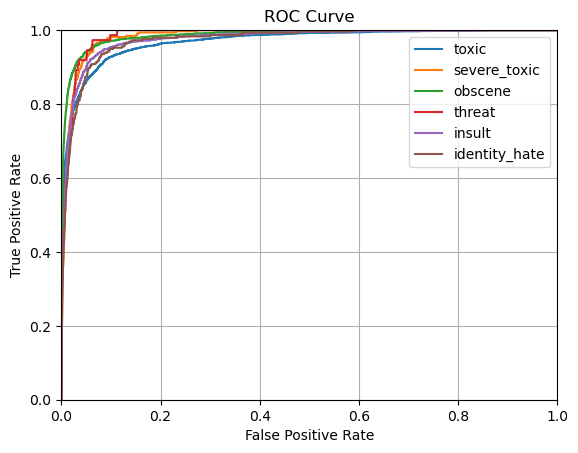

In [55]:
plot_pipeline_roc_curve(LR_pipeline,X_train,X_test,y_train,y_test)